# TinyStories Interpretability Notebook

This notebook aims to extract some interpretable feature circuit using transcoders trained on a 2-layer transformer model trained on TinyStories, a dataset containing fairytales.

First, start by importing the right libraries and setting up the model, the transcoder and the tokenizer.

In [1]:
from transcoder import CrossLayerTranscoder
from config import TranscoderConfig, ModelConfig
from gpt import GPTLanguageModel
from datasets import load_dataset
import torch
import torch.nn as nn
from torch import einsum
from typing import Optional, Union
from transcoder import CrossLayerTranscoder
from transformers import GPT2Tokenizer

torch.manual_seed(42)

# Set number of test prompts to visualize
num_test_prompts = 30

# Load tinystories dataset and filter it
dataset = load_dataset('roneneldan/TinyStories', split='train')
test_prompts = dataset[:num_test_prompts]['text']

# Load config files
t_cfg = TranscoderConfig()
m_cfg = ModelConfig()

t_cfg.save_path = f"../../{t_cfg.save_path}"
m_cfg.model_path = f"../../{m_cfg.model_path}"

# Initialize Transcoder, Model and Tokenizer
tc = CrossLayerTranscoder.load_model(t_cfg, m_cfg)
m = GPTLanguageModel.from_pretrained(m_cfg).to(m_cfg.device)
tok = GPT2Tokenizer.from_pretrained("gpt2")
tok.pad_token = tok.eos_token

/storage_1/lruggeri/miniconda3/envs/wavelets/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now we will start to investigate which features activates the most on the last token of a given prompt. <br>
Specifically, we will search in both layers of the model to find some good features.

Here we will use *which_most_act* function which returns which features are activating the most on a the last token of a given prompt

In [2]:
from utils import *

text = [
    'Once upon a'
]
logits = which_most_act(text, tok, tc)

--- Layer 0 ---
Feat #1: 7659
Feat #2: 6490
Feat #3: 2915
Feat #4: 6384
Feat #5: 2545
--- Layer 1 ---
Feat #1: 3462
Feat #2: 1932
Feat #3: 3327
Feat #4: 696
Feat #5: 8059


However, visualizing it like this is not satisfying. We don't know whether that feature is specific for that token or it activates also in other contexts. Therefore, I've developed this dash application to see where the features activates the most on a given set of input prompts. <br>
Here from the dropdown you can select the features that you want to visualize in both layers and the tokens will be coloured based on the feature's activation in that specific token. 

## Visualizing Activations through Dash

Here you have a very simple dash app that takes as input the sequences, the model and outputs a visualization for identifying which features are active on a given prompt. 

In [4]:
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output, Dash
import dash_bootstrap_components as dbc
import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import torch

# Filter out prompts with specific entry ('worry' in this case, we will need that later)
pattern = 'Once'
filtered_prompts = dataset.filter(lambda x: pattern in x['text'])
test_prompts = filtered_prompts[:num_test_prompts]['text']

# Example tokenized sequences and activations (token-level)
prompts = test_prompts
tokens = [tok.tokenize(prompt) for prompt in prompts]
input_ids = tok(prompts, return_tensors='pt', truncation=True, max_length=tc.model_cfg.block_size)['input_ids']
input_ids = input_ids.to(tc.cfg.device)

outs = tc(input_ids)

# shape: (3 sequences, 7 tokens, 7 features)
activations = outs['feature_activations']
num_features = tc.cfg.num_features

# Color token helper
def color_token(token, act, vmin, vmax):
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = matplotlib.colormaps['YlOrRd']
    rgba = cmap(norm(act))
    color = f"rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, 0.9)"
    return html.Span(token, title=f"Activation: {act:.4f}", style={
        "backgroundColor": color,
        "padding": "2px",
        "margin": "1px",
        "fontFamily": "monospace"
    })

# Render a sequence with token-level activations
def render_sequence(tokens, activations, eos_token='</s>'):
    if isinstance(activations, torch.Tensor):
        activations = activations.detach().cpu().numpy()

    vmin, vmax = np.min(activations), np.max(activations)
    elements = []

    for token, act in zip(tokens, activations):
        clean_token = token.replace('Ġ', '').strip()  # remove Ġ and extra spaces
        if clean_token == '' or clean_token == eos_token:
            continue  # skip empty or eos tokens
        elements.append(color_token(clean_token, act, vmin, vmax))

    return html.Div(
        elements,
        style={"display": "flex", "flexWrap": "wrap", "marginBottom": "10px"}
    )


# Build app
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container([
    html.H3("Sparse Feature Activation Visualizer"),

    dbc.Row([
        dbc.Col([
            dbc.Label("Select Transcoder Layer:"),
            dcc.Dropdown(
                id="layer-dropdown",
                options=[{"label": f"Layer {i}", "value": i} for i in range(tc.model_cfg.n_layer)],
                value=0,
                clearable=False
            )
        ]),
        dbc.Col([
            dbc.Label("Select Feature Index:"),
            dcc.Dropdown(
                id="feature-dropdown",
                options=[{'label': f'Feature {i}', 'value': i} for i in range(num_features)],
                value=0,
                clearable=False
            )
        ]) 
    ]),

    html.Hr(),

    html.Div(id="sequence-view")
], fluid=True)

# Callback to update sequences based on feature index
@app.callback(
    Output("sequence-view", "children"),
    [Input("layer-dropdown", "value"),
     Input("feature-dropdown", "value")]
)
def update_feature_view(selected_layer, selected_feature):
    # Extract from activations assuming shape: (B, T, num_features, num_layers)
    
    acts_for_layer = activations[selected_layer][:, :, selected_feature]  # shape: (B, T)

    sequence_rows = []
    for i in range(len(tokens)):
        toks = tokens[i]
        acts = acts_for_layer[i]
        row = html.Div([
            html.Strong(f"Sequence {i}:"), render_sequence(toks, acts)
        ])
        sequence_rows.append(row)

    return sequence_rows


app.run(debug=True, port=8052)


## The "Don't worry" circuit

Take for example features 6764 and 5338 from layer 0. They activates particularly on token **'t** when it follows the token **don**. Moreover, these features seem responsible for the output of token **worry**. Therefore, we can speculate that these features are constructing a circuit that make the model say; *"Don't worry"*. <br>
Let's see if this speculation is correct by switching off these features in a context where the model wants to output the token **worry**. 

In [4]:
from utils import activate_features_across_layers, plot_top_tokens_comparison

torch.manual_seed(42)

# Text where the 't token is not followed by 'worry'
text = 'The old man said: "I can\'t'

# Forcefully activate feature 6764 in layer 0
original_logits, modified_logits = activate_features_across_layers(text, feature_activation={0: [6764]}, activation_value=200.0, m=m, tc=tc, tok=tok)


Original logits. Best Token 1064 with value 10.804633140563965. Token:  find with p=0.12120366096496582
Modified logits. Best Token 5490 with value 11.551329612731934. Token:  worry with p=0.7195234298706055
Probabilities changed from 0.00014963549620006233 to 0.7195234298706055


Now the model outputs worry **with a probability of roughly 72%** on a context in which worry was considered with a confidence of less than 0.1%. Let's plot the differences in the model's logits.

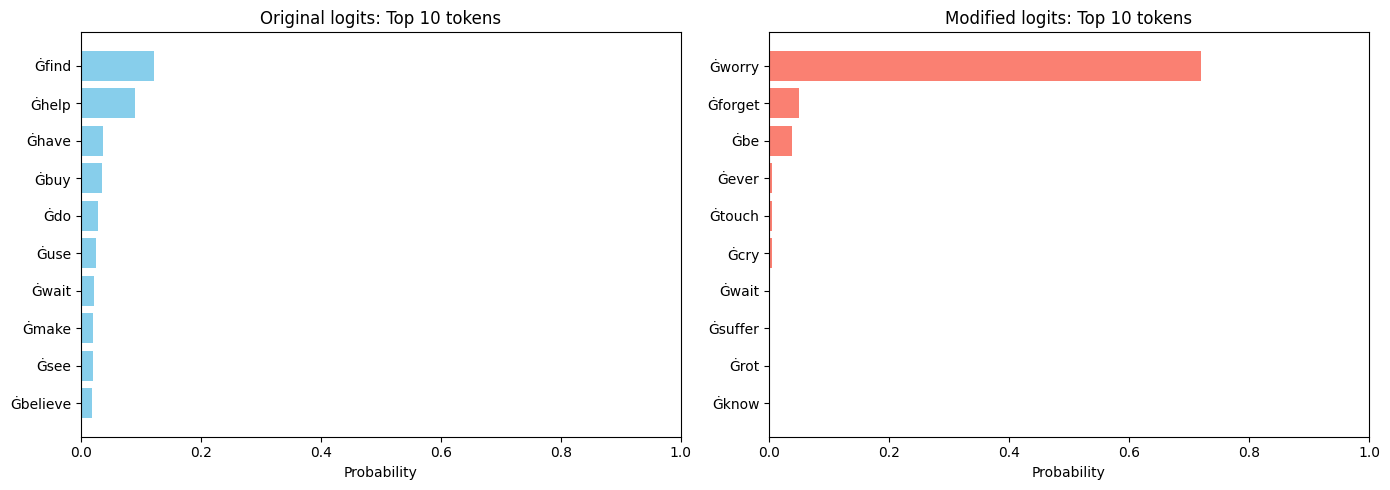

In [5]:
# Plot model's logits differences
plot_top_tokens_comparison(original_logits, modified_logits, tok, top_k=10)

As you can the the model shifts from outputting "find" to outputting "worry" with a really good confidence.

## The "Once upon a time" circuit

Now let's consider another pattern, usually present in fairy tales: "Once upon a time". From the dash app, we can see how feature 1932 from layer 1 activates the most on "a" before outputting "time". So that could be our **starting point**.

In [6]:
from circuit_tracing import *

text = 'Once upon a'
input_ids = tok(text, return_tensors='pt')['input_ids'].cuda()

logits, cache = m.run_with_cache(input_ids)

layer = 1
token = 2
act_feat = 1932
f_target = tc.encoders[layer].weight[act_feat, :]

# # Feature to trace
fv = FeatureVector(
    component_path=[Component(layer, ComponentType.MLP, token=token)],
    vector=f_target.detach().clone(),
    layer=layer,
    sublayer="resid_mid",
    token=token
)

all_paths = greedy_get_top_paths(m, tc, cache, fv)
print_all_paths(all_paths)


--- Paths of size 2 ---
Path [0][0]: mlp1@2@2 <- mlp0tc[2915]@2: 2.8
Path [0][1]: mlp1@2@2 <- attn0[1]@2: 0.66
Path [0][2]: mlp1@2@2 <- attn0[0]@2: 0.29
Path [0][3]: mlp1@2@2 <- attn0[3]@0: 0.24
Path [0][4]: mlp1@2@2 <- attn0[2]@1: 0.21
--- Paths of size 3 ---
Path [1][0]: mlp1@2@2 <- mlp0tc[2915]@2: 2.8 <- mlp0tc[2915]@2: 2.8
Path [1][1]: mlp1@2@2 <- mlp0tc[2915]@2: 2.8 <- attn0[1]@2: 0.66
Path [1][2]: mlp1@2@2 <- mlp0tc[2915]@2: 2.8 <- attn0[0]@2: 0.29
Path [1][3]: mlp1@2@2 <- mlp0tc[2915]@2: 2.8 <- attn0[3]@0: 0.24
Path [1][4]: mlp1@2@2 <- mlp0tc[2915]@2: 2.8 <- attn0[2]@1: 0.21


This notation means that feature 1932 in layer 1 is being modulated by feature 2915 in layer 0, which itself receives contributions from **attention head 3 at token position 0** and **attention head 2 at token position 1**. In plain language: the feature that predicts *“time”* is activated through a chain that depends on the tokens *“once”* and *“upon”*.

Altogether, this paints a coherent picture. The model has carved out a small, **interpretable** circuit that detects the prefix *“once upon a …”* and channels this information forward to bias the output toward *“time”*.

Now let's test this circuit in a situation in which "time" should not be the correct output.

In [7]:
text = 'This is a'

torch.manual_seed(42)
# Forcefully activate feature 6764 in layer 0
original_logits, modified_logits = activate_features_across_layers(text, feature_activation={0: [2915]}, activation_value=100.0, m=m, tok=tok, tc=tc)

Original logits. Best Token 2041 with value 11.507708549499512. Token:  special with p=0.2899576723575592
Modified logits. Best Token 640 with value 14.536004066467285. Token:  time with p=0.9728103876113892
Probabilities changed from 4.9016594857675955e-05 to 0.9728103876113892


As you can see, by activating feature 2915 (the one that modules feature 1932 in layer 1), "time" probability skyrockets from <0.001% to 97%. In the original setting, the model would have outputted "special" with probability 28%.

Let's see again the differences for the top 10 logits.

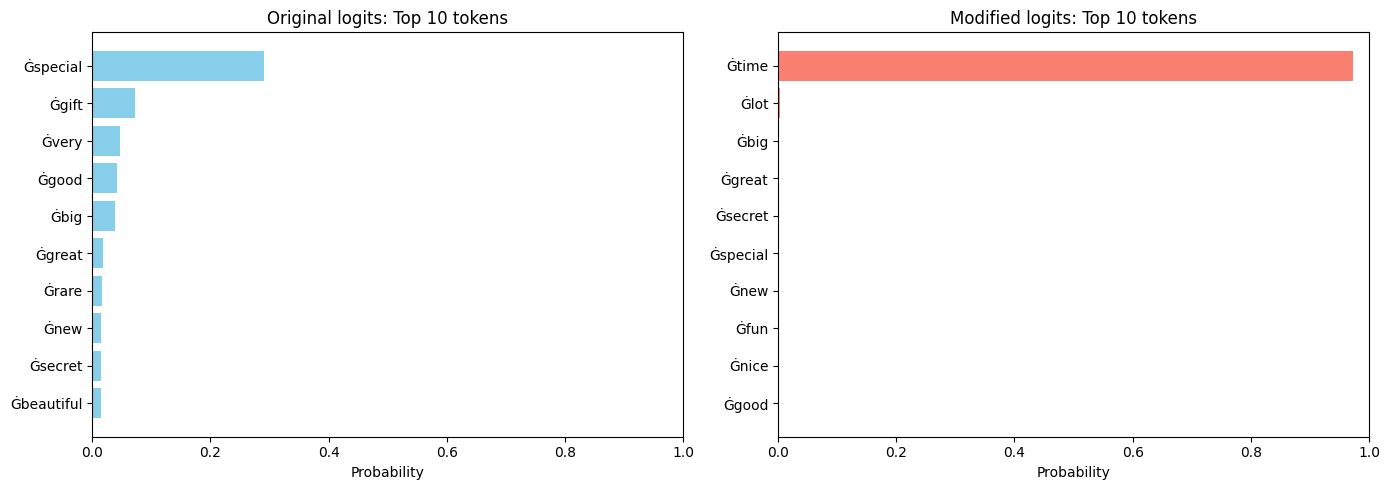

In [11]:
# Plot model's logits differences
plot_top_tokens_comparison(original_logits, modified_logits, tok, top_k=10)

As you can the the model shifts **completely** from outputting "special" to outputting "time" with nearly 100% confidence.